# CPU vs GPU vs TPU Speed Test on AI

This notebook is a demo developed by VASS AI team that shows the performance in terms of speed and accuracy of a deep learning model trained in the 3 main available processing units. This demo train and evaluate the same DL model over the same dataset and compare the time and accuracy that takes each processing unit. 

### CPU
The CPU (central processing unit) of a computer is usually called the “brain” of a computer. Whenever a user inputs data or instruction, the CPU moves it from RAM for calculation. It gives back the output to the RAM via the system bus. These operations are invoked by a signal called a clock cycle (sequentially).

For this notebook (Colab): Intel(R) Xeon(R) CPU @ 2.30GHz 1core

### GPU
A graphical processing unit (GPU) has smaller-sized logical cores or arithmetic logic units, control units and memory whose basic design is to process a set of simpler and more identical calculations in parallel, like calculations related to the matrix.

For this notebook (Colab): Nvidia Tesla K80 GPU @ 12GB GDDR5

### TPU
A tensor processing unit (TPU) is an application-specific integrated circuit (ASIC) developed by Google specifically for a neural network. TPUs are specialized in running linear algebra calculation which is heavily used in Machine Learning and Deep Learning applications. In general, TPUs can handle most of the calculations related to the matrix. TPUs can also be used for models that require high arithmetic precision.

For this notebook (Colab): Cloud TPU v2-8 @ 8cores 64GB

### CPU vs GPU vs TPU

The fundamental difference between CPU, GPU and TPU is the way these circuits are engineered and the way they process the instructions. The below diagram explains how these three chips do arithmetic calculations. 

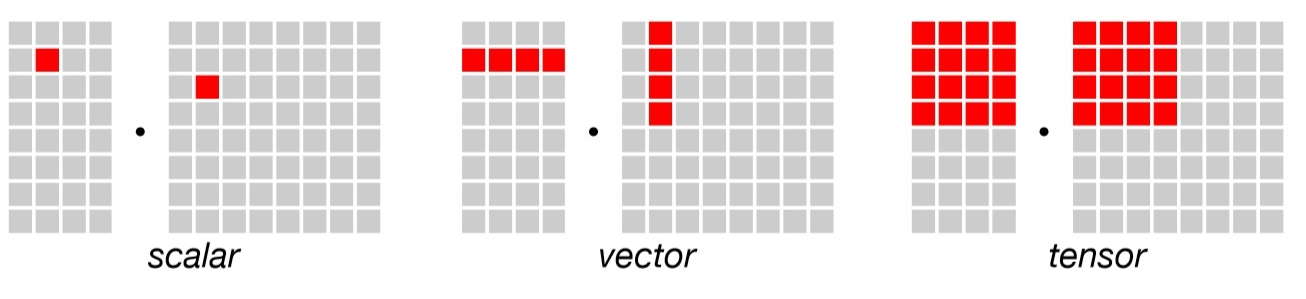

CPU which is designed to handle scalar calculations can do 1x1 data unit. On the other hand, GPUs are specifically designed to do vector calculations that is 1xN data unit. TPU does tensor calculations which can go up to NxN calculations. When we look from the no. of operations these chips can handle, CPU can handle tens of operation per cycle while GPU can handle tens of thousands of operation per cycle and TPU can handle up to 128000 operations per cycle.

[source](https://www.linkedin.com/pulse/cpu-vs-gpu-tpu-heart-ai-karthikeyan-prakash?trk=read_related_article-card_title)

## Notebook usage instructions

**The notebook has been previously executed to show the results in terms of speed difference between CPU, GPU and TPU training a convolutional neural network on MNIST dataset.** 

Anyway, if you want to excute this notebook by your own, please follow the intructions below:

  1. Go to _Runtime > Change runtime type_ and select None
  2. Execute cells only below _Configuration_ and _CPU_ sections
  3. Copy the list of times obtained with CPU training in _cpu_time_ variable under _CPU vs GPU vs TPU_ section
  4. Go to _Runtime > Change runtime type_ and select GPU
  5. Execute cells only below _Configuration_ and _GPU_ sections
  6. Copy the list of times obtained with GPU training in _gpu_time_ variable under _CPU vs GPU vs TPU_ section
  7. Go to _Runtime > Change runtime type_ and select TPU
  8. Execute cells only below _Configuration_ and _TPU_ sections
  9. Copy the list of times obtained with TPU training in _tpu_time_ variable under _CPU vs GPU vs TPU_ section
  10. Finally, execute cells under _CPU vs GPU vs TPU_ section to compare the 3 processing units

## Configuration

In [ ]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
import tensorflow_datasets as tfds
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import time
import os

In [ ]:
# Constants that define the model architecture and training process
N_FILTER = 32
N_DENSE = 512
ACTIVATION_FUNC = 'relu'
DROPOUT_RATE = 0.7
LEARNING_RATE = 0.001
N_CLASSES = 10
N_EPOCHS = 5

BATCH_SIZES = [8*2**i for i in range(11)]

In [ ]:
def build_dataset(n_classes):
  '''
  Download, pre-process and normalize the training and test data

  Args:
  - n_classes (int): Number of classes in which the samples are categorized

  Return:
  Two tuples with trainig and test datasets (x_train, y_train), (x_test, y_test)
  '''
  
  # Dowload dataset
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

  # Preprocess data
  img_rows, img_cols = 28, 28
  input_shape = (img_rows, img_cols, 1)

  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  # Normalize data
  x_train = x_train / 255.0
  x_test = x_test / 255.0

  # Prepare labels
  y_train = tf.keras.utils.to_categorical(y_train, n_classes)
  y_test = tf.keras.utils.to_categorical(y_test, n_classes)

  print('Train shape: X -> {}, Y -> {}'.format(x_train.shape, y_train.shape))
  print('Test shape: X -> {}, Y -> {}'.format(x_test.shape, y_test.shape))

  return (x_train, y_train), (x_test, y_test)

In [ ]:
def build_model(n_filter, n_dense, activation_func, dropout_rate):
  '''
  Builds the deep learning model

  Args:
  - n_filter (int): Number of filters per each convolutional layer
  - n_dense (int): Number of neurons in the last dense layer
  - activation_func (str): Activation function to be used in all layers (except last one)
  - dropout_rate (float): Dropout rate to be applied in dense layer

  Return:
  Keras sequential CNN model
  '''
  model = Sequential()

  model.add(Conv2D(n_filter, (3, 3), activation=activation_func, input_shape=(28, 28, 1),padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Conv2D(n_filter, (3, 3), activation=activation_func, padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(2 * n_filter, (3, 3), activation=activation_func,padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Conv2D(2 * n_filter, (3, 3), activation=activation_func,padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())                        
  model.add(Dense(n_dense, activation=activation_func))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))

  return model

## CPU

In [ ]:
# Train model with CPU

cpu_time, cpu_val_acc = [], []
with tf.device("/CPU:0"):
  # Data is pre-processed
  (x_train, y_train), (x_test, y_test) = build_dataset(N_CLASSES)

  # DL model is defined and compiled
  model = build_model(N_FILTER, N_DENSE, ACTIVATION_FUNC, DROPOUT_RATE)
  model.summary()
  print()

  optim = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

  # Check that the model is training on CPU
  assert(len(tf.config.list_physical_devices('GPU')) == 0)
  assert(len(tf.config.list_logical_devices('TPU')) == 0)
  print('\nTraining on ' + tf.config.list_physical_devices('CPU')[0].device_type + '\n')

  # Train the model over different batch sizes
  for k in BATCH_SIZES:
    print('\nBatch size: ' + str(k))
    t_start = time.time()
    model.fit(x_train, y_train, batch_size=k, epochs=N_EPOCHS)
    cpu_time.append(int(time.time() - t_start))

    val_acc = model.evaluate(x_test, y_test, steps=1)
    cpu_val_acc.append(val_acc[1])

11501568/11490434 [==============================] - 0s 0us/step
Train shape: X -> (60000, 28, 28, 1), Y -> (60000, 10)
Test shape: X -> (10000, 28, 28, 1), Y -> (10000, 10)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv

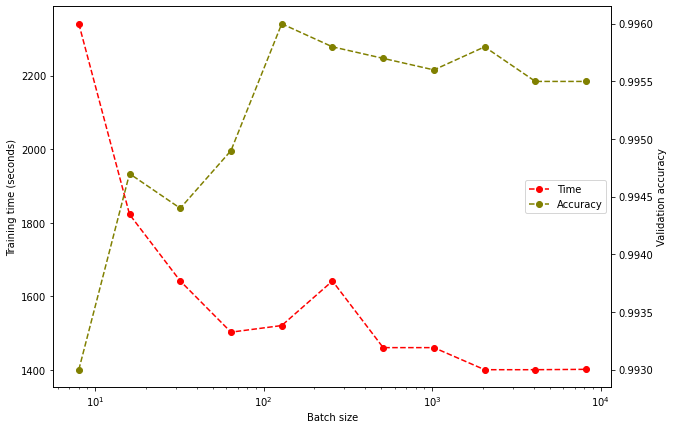

In [ ]:
# Plot CPU results
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
lns1 = ax1.plot(BATCH_SIZES, cpu_time, color='red', linestyle='--', marker='o', label='Time')
lns2 = ax2.plot(BATCH_SIZES, cpu_val_acc, color='olive', linestyle='--', marker='o', label='Accuracy')

ax1.set_xscale('log')
ax1.set_xlabel('Batch size')
ax1.set_ylabel('Training time (seconds)')
ax2.set_ylabel('Validation accuracy')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.show()

In [ ]:
# If you execute the notebook, copy-paste this cell output in cpu_time and cpu_val_acc variables 
# on the last cell of the notebook in order to compare the 3 processing units
print('Processing time per batch size:', str(cpu_time))
print('Validation accuracy per batch size:', str([round(x, 4) for x in cpu_val_acc]))

Processing time per batch size: [2341, 1823, 1642, 1503, 1521, 1642, 1461, 1461, 1401, 1401, 1402]
Validation accuracy per batch size: [0.993, 0.9947, 0.9944, 0.9949, 0.996, 0.9958, 0.9957, 0.9956, 0.9958, 0.9955, 0.9955]


## GPU

In [ ]:
# Train model with GPU

gpu_time, gpu_val_acc = [], []
with tf.device("/GPU:0"):
  # Data is pre-processed
  (x_train, y_train), (x_test, y_test) = build_dataset(N_CLASSES)

  # DL model is defined and compiled
  model = build_model(N_FILTER, N_DENSE, ACTIVATION_FUNC, DROPOUT_RATE)
  model.summary()
  print()

  optim = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

  # Check that the model is training on GPU
  assert(len(tf.config.list_physical_devices('GPU')) == 1)
  assert(len(tf.config.list_logical_devices('TPU')) == 0)
  print('\nTraining on ' + tf.config.list_physical_devices('GPU')[0].device_type + '\n')

  # Train the model over different batch sizes
  for k in BATCH_SIZES:
    print('\nBatch size: ' + str(k))
    t_start = time.time()
    model.fit(x_train, y_train, batch_size=k, epochs=N_EPOCHS)
    gpu_time.append(int(time.time() - t_start))

    val_acc = model.evaluate(x_test, y_test, steps=1)
    gpu_val_acc.append(val_acc[1])

Train shape: X -> (60000, 28, 28, 1), Y -> (60000, 10)
Test shape: X -> (10000, 28, 28, 1), Y -> (10000, 10)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
___________

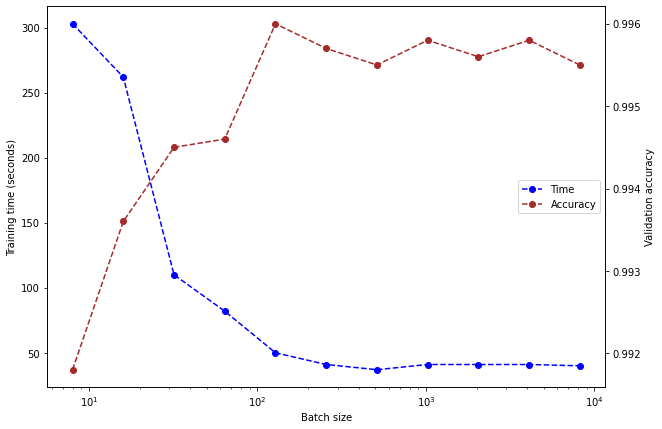

In [ ]:
# Plot GPU results
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
lns1 = ax1.plot(BATCH_SIZES, gpu_time, color='blue', linestyle='--', marker='o', label='Time')
lns2 = ax2.plot(BATCH_SIZES, gpu_val_acc, color='brown', linestyle='--', marker='o', label='Accuracy')

ax1.set_xscale('log')
ax1.set_xlabel('Batch size')
ax1.set_ylabel('Training time (seconds)')
ax2.set_ylabel('Validation accuracy')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.show()

In [ ]:
# If you execute the notebook, copy-paste this cell output in gpu_time and gpu_val_acc variables 
# on the last cell of the notebook in order to compare the 3 processing units
print('Processing time per batch size:', str(gpu_time))
print('Validation accuracy per batch size:', str([round(x, 4) for x in gpu_val_acc]))

Processing time per batch size: [303, 262, 110, 82, 50, 41, 37, 41, 41, 41, 40]
Validation accuracy per batch size: [0.9918, 0.9936, 0.9945, 0.9946, 0.996, 0.9957, 0.9955, 0.9958, 0.9956, 0.9958, 0.9955]


## TPU

In [ ]:
def build_dataset_tpu(batch_size, split):
  '''
  Download, pre-process and normalize the data. To improve the performance in 
  TPU, and online version of MNIST dataset stored in GCS is nedeed, so the 
  build_dataset function has some changes.

  Args:
  - batch_size (int): Size of the batch to load the data in memory
  - split (str): Split of the dataset to pre-process (train|test)

  Return
  Pre-processed dataset
  '''
  assert(split in ['train', 'test'])
  
  dataset, info = tfds.load(name='mnist', split=split, with_info=True,
                            as_supervised=True, try_gcs=True)

  # Normalize the input data.
  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  dataset = dataset.map(scale)

  # Only shuffle and repeat the dataset in training. The advantage of having an
  # infinite dataset for training is to avoid the potential last partial batch
  # in each epoch, so that you don't need to think about scaling the gradients
  # based on the actual batch size.
  if split == 'train':
    dataset = dataset.shuffle(10000)
    dataset = dataset.repeat()

  dataset = dataset.batch(batch_size)

  return dataset

In [ ]:
# Configure TPU
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

except KeyError:
  print('TPU not found')

# Train model with TPU

tpu_time, tpu_val_acc = [], []
with strategy.scope():
  # DL model is defined and compiled
  model = build_model(N_FILTER, N_DENSE, ACTIVATION_FUNC, DROPOUT_RATE)

  optim = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  model.compile(optimizer=optim, steps_per_execution=50, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  # Check that the model is training on TPU
  assert(len(tf.config.list_physical_devices('GPU')) == 0)
  assert(len(tf.config.list_logical_devices('TPU')) >= 1)
  print('Training on ' + tf.config.list_logical_devices('TPU')[0].device_type)

  # Train the model over different batch sizes
  for k in BATCH_SIZES:
    steps_per_epoch = 60000 // k
    validation_steps = 10000 // k

    # Data is pre-processed
    train_dataset = build_dataset_tpu(k, 'train')
    test_dataset = build_dataset_tpu(k, 'test')

    print('\nBatch size: ' + str(k))
    t_start = time.time()
    model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch)
    tpu_time.append(int(time.time() - t_start))

    val_acc = model.evaluate(test_dataset, steps=1)
    tpu_val_acc.append(val_acc[1])

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.65.136.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.65.136.66:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Training on TPU

Batch size: 8
Epoch 1/5
7500/7500 [==============================] - 44s 6ms/step - loss: 2.2869 - accuracy: 0.1362
Epoch 2/5
7500/7500 [==============================] - 35s 5ms/step - loss: 2.0370 - accuracy: 0.3572
Epoch 3/5
7500/7500 [==============================] - 34s 5ms/step - loss: 2.0688 - accuracy: 0.2738
Epoch 4/5
7500/7500 [==============================] - 34s 5ms/step - loss: 2.1211 - accuracy: 0.2325
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 703753920.0000 - accuracy: 0.1250

Batch size: 16
Epoch 1/5
3750/3750 [==============================] - 17s 5ms/step - loss: 13.4469 - accuracy: 0.1594
Epoch 2/5
3750/3750 [==============================] - 17s 5ms/step - loss: 2.5097 - accuracy: 0.2437
Epoch 3/5
3750/3750 [==============================] - 17s 5ms/step - loss: 2.0628 - accuracy: 0.2695
Epoch 4/5
3750/3750 [==============================] - 17s 5ms/step - loss: 2.0517 - accuracy: 0.2725
Epoch 5/5
1/1 [===================

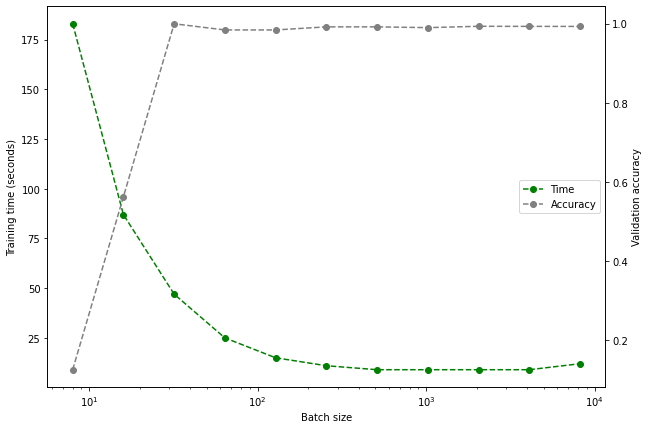

In [ ]:
# Plot TPU results
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
lns1 = ax1.plot(BATCH_SIZES, tpu_time, color='green', linestyle='--', marker='o', label='Time')
lns2 = ax2.plot(BATCH_SIZES, tpu_val_acc, color='gray', linestyle='--', marker='o', label='Accuracy')

ax1.set_xscale('log')
ax1.set_xlabel('Batch size')
ax1.set_ylabel('Training time (seconds)')
ax2.set_ylabel('Validation accuracy')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.show()

In [ ]:
# If you execute the notebook, copy-paste this cell output in tpu_time and tpu_val_acc variables 
# on the last cell of the notebook in order to compare the 3 processing units
print('Processing time per batch size:', str(tpu_time))
print('Validation accuracy per batch size:', str([round(x, 4) for x in tpu_val_acc]))

Processing time per batch size: [183, 87, 47, 25, 15, 11, 9, 9, 9, 9, 12]
Validation accuracy per batch size: [0.125, 0.5625, 1.0, 0.9844, 0.9844, 0.9922, 0.9922, 0.9902, 0.9937, 0.9934, 0.9933]


## CPU vs GPU vs TPU

In [ ]:
# If you execute the notebook, paste here the output of the previous cells 
# with the list of times (in secods) and accuracy of each processing unit
cpu_time = [2341, 1823, 1642, 1503, 1521, 1642, 1461, 1461, 1401, 1401, 1402]
cpu_val_acc = [0.993, 0.9947, 0.9944, 0.9949, 0.996, 0.9958, 0.9957, 0.9956, 0.9958, 0.9955, 0.9955]

gpu_time = [303, 262, 110, 82, 50, 41, 37, 41, 41, 41, 40]
gpu_val_acc = [0.9918, 0.9936, 0.9945, 0.9946, 0.996, 0.9957, 0.9955, 0.9958, 0.9956, 0.9958, 0.9955]

tpu_time = [183, 87, 47, 25, 15, 11, 9, 9, 9, 9, 12]
tpu_val_acc = [0.125, 0.5625, 1.0, 0.9844, 0.9844, 0.9922, 0.9922, 0.9902, 0.9937, 0.9934, 0.9933]

assert(len(cpu_time) == len(cpu_val_acc))
assert(len(gpu_time) == len(gpu_val_acc))
assert(len(tpu_time) == len(tpu_val_acc))

In [ ]:
print('GPU is {}x faster on average that CPU'.format(round(np.mean(np.array(cpu_time) / np.array(gpu_time)), 1)))
print('TPU is {}x faster on average that CPU'.format(round(np.mean(np.array(cpu_time) / np.array(tpu_time)), 1)))
print('TPU is {}x faster on average that GPU'.format(round(np.mean(np.array(gpu_time) / np.array(tpu_time)), 1)))

GPU is 27.0x faster on average that CPU
TPU is 102.9x faster on average that CPU
TPU is 3.5x faster on average that GPU


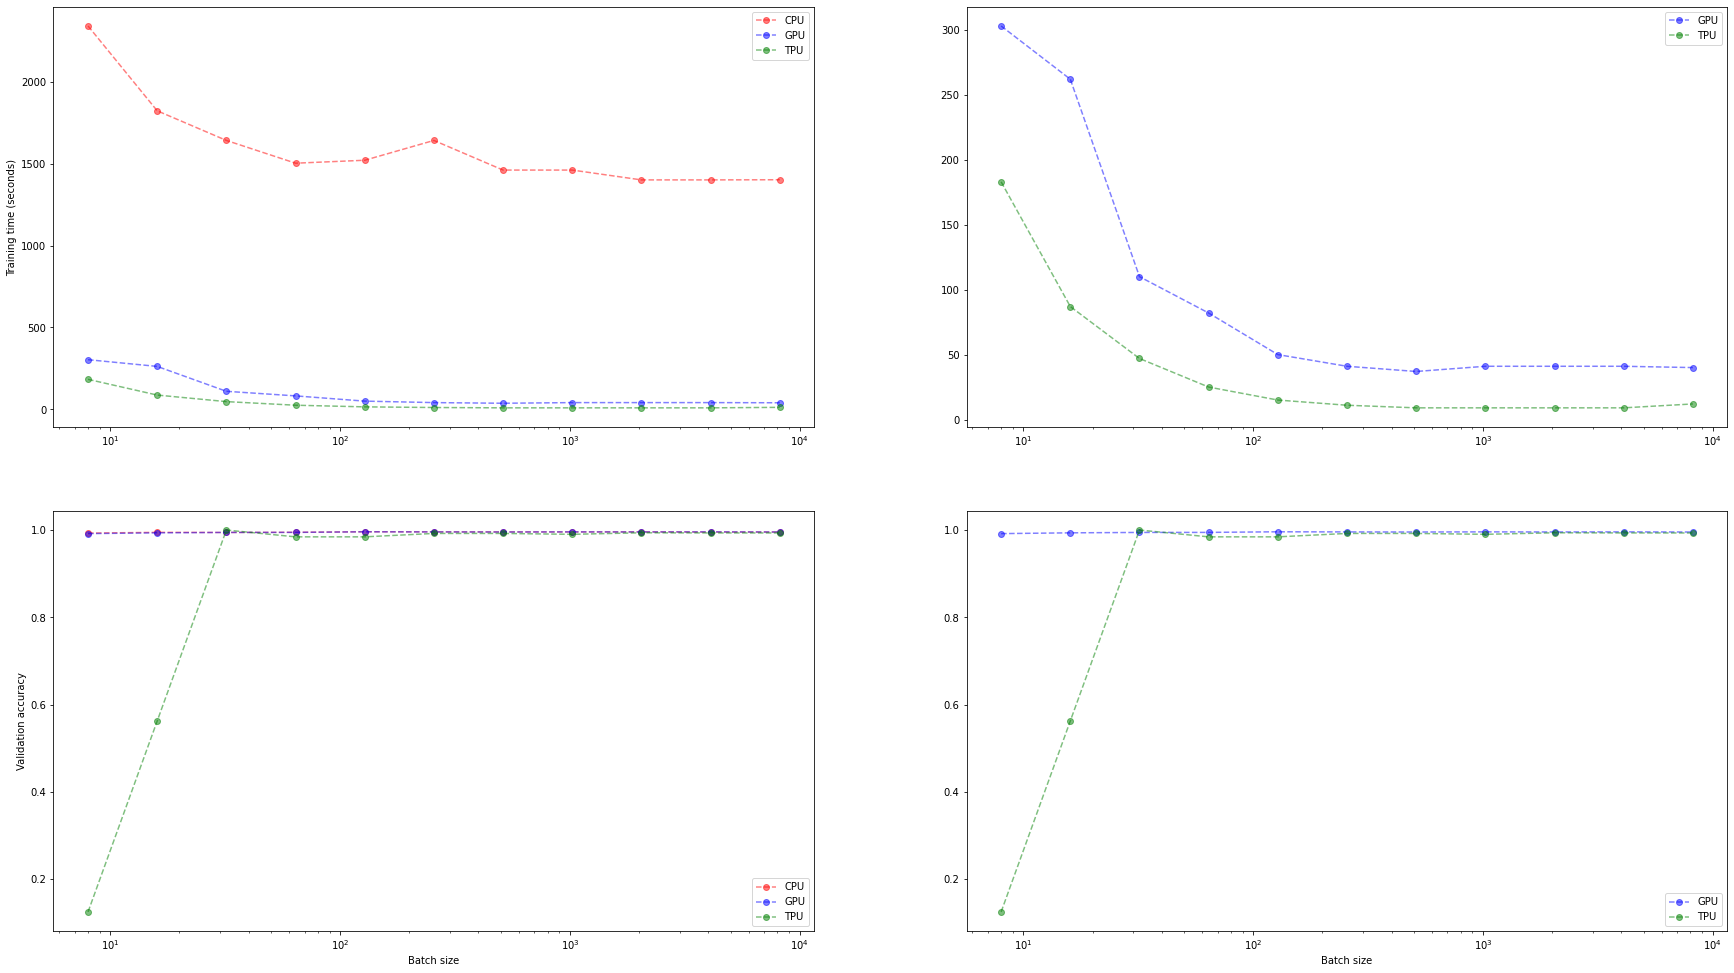

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30,17))

ax1.plot(BATCH_SIZES, cpu_time, color='red', alpha=0.5, linestyle='--', marker='o', label='CPU')
ax1.plot(BATCH_SIZES, gpu_time, color='blue', alpha=0.5, linestyle='--', marker='o', label='GPU')
ax1.plot(BATCH_SIZES, tpu_time, color='green', alpha=0.5, linestyle='--', marker='o', label='TPU')
ax1.set_xscale('log')
ax1.set_ylabel('Training time (seconds)')
ax1.legend()

ax2.plot(BATCH_SIZES, gpu_time, color='blue', alpha=0.5, linestyle='--', marker='o', label='GPU')
ax2.plot(BATCH_SIZES, tpu_time, color='green', alpha=0.5, linestyle='--', marker='o', label='TPU')
ax2.set_xscale('log')
ax2.legend()

ax3.plot(BATCH_SIZES, cpu_val_acc, color='red', alpha=0.5, linestyle='--', marker='o', label='CPU')
ax3.plot(BATCH_SIZES, gpu_val_acc, color='blue', alpha=0.5, linestyle='--', marker='o', label='GPU')
ax3.plot(BATCH_SIZES, tpu_val_acc, color='green', alpha=0.5, linestyle='--', marker='o', label='TPU')
ax3.set_xscale('log')
ax3.set_xlabel('Batch size')
ax3.set_ylabel('Validation accuracy')
ax3.legend()

ax4.plot(BATCH_SIZES, gpu_val_acc, color='blue', alpha=0.5, linestyle='--', marker='o', label='GPU')
ax4.plot(BATCH_SIZES, tpu_val_acc, color='green', alpha=0.5, linestyle='--', marker='o', label='TPU')
ax4.set_xscale('log')
ax4.set_xlabel('Batch size')
ax4.legend()

plt.show()

## Conclusions

In the plots above, we can see the training time in the first row and the validation accuracy in the second row. In both, we have ploted the results without CPU (plots on the right) to achieve a better visualization of the GPU/TPU results, specially for training time.

Regarding training time, CPU is the slowest processing unit, followed by GPU and TPU. **TPU is the fastest processing unit, 103 times faster than CPU and 3.5 times faster than GPU**. 

The **accuracy achieved for the 3 tested processing units is the same**. Please take into account that DL models use stocastic process, so the results are not exactly the same as expected, but they are close enough to be considered the same results. Due to the TPU architecture, low batch sizes do not use their complete computation power and it is expected that the accuracy obtained is poor. ([more info](https://cloud.google.com/tpu/docs/performance-guide)).

In conclusion, **CPU is not the best alternative to train deep learning models** as the training time is extremely high even with small models and datasets. **This kind of models needs GPU/TPU**. TPU is faster than GPU, but also is expensive, so the model and the available dataset conditionates the use case.